<h1 align=center> Data Engineering Project: European Soccer ⚽️⚽️⚽️ </h1>

| [<img src="https://avatars0.githubusercontent.com/u/18689888" width="150px;" height="150px;"/><br /><sub><b>Amr M. Kayid</b></sub>](https://github.com/AmrMKayid)| [<img src="https://avatars2.githubusercontent.com/u/25725667" width="150px;" height="150px;"/><br /><sub><b>Omar ElSayed</b></sub>](https://github.com/OmarElSayed97/) | [<img src="https://avatars2.githubusercontent.com/u/25728207" width="150px;" height="150px;"/><br /><sub><b>Sama AlShareef</b></sub>](https://github.com/SamaAlshareef) | [<img src="https://avatars2.githubusercontent.com/u/36411887" width="150px;" height="150px;"/><br /><sub><b>Mayar Kamali</b></sub>](https://github.com/MayarLotfy) | [<img src="https://avatars2.githubusercontent.com/u/25841617" width="150px;" height="150px;"/><br /><sub><b>Zeiad Helmy</b></sub>](https://github.com/zeiad133) | 
| :---: | :---: | :---: | :---: | :---: | 
| **37-15594** | **37-6537** |  **37-705** |  **37-16401** |  **37-14353** | 
| **T10** | **T10** | **T10** | **T10** | **T10** | 

# Overview

What you get:

+25,000 matches
+10,000 players
11 European Countries with their lead championship
Seasons 2008 to 2016
Players and Teams' attributes* sourced from EA Sports' FIFA video game series, including the weekly updates
Team line up with squad formation (X, Y coordinates)
Betting odds from up to 10 providers
Detailed match events (goal types, possession, corner, cross, fouls, cards etc...) for +10,000 matches
*16th Oct 2016: New table containing teams' attributes from FIFA !

Original Data Source:

You can easily find data about soccer matches but they are usually scattered across different websites. A thorough data collection and processing has been done to make your life easier. I must insist that you do not make any commercial use of the data. The data was sourced from:

http://football-data.mx-api.enetscores.com/ : scores, lineup, team formation and events

http://www.football-data.co.uk/ : betting odds. Click here to understand the column naming system for betting odds:

http://sofifa.com/ : players and teams attributes from EA Sports FIFA games. FIFA series and all FIFA assets property of EA Sports.

When you have a look at the database, you will notice foreign keys for players and matches are the same as the original data sources. I have called those foreign keys "api_id".

Improving the dataset:

You will notice that some players are missing from the lineup (NULL values). This is because I have not been able to source their attributes from FIFA. This will be fixed overtime as the crawling algorithm is being improved. The dataset will also be expanded to include international games, national cups, Champion's League and Europa League. Please ask me if you're after a specific tournament.

Please get in touch with me if you want to help improve this dataset.

CLICK HERE TO ACCESS THE PROJECT GITHUB

Important note for people interested in using the crawlers: since I first wrote the crawling scripts (in python), it appears sofifa.com has changed its design and with it comes new requirements for the scripts. The existing script to crawl players ('Player Spider') will not work until i've updated it.

Exploring the data:

Now that's the fun part, there is a lot you can do with this dataset. I will be adding visuals and insights to this overview page but please have a look at the kernels and give it a try yourself ! Here are some ideas for you:

The Holy Grail... ... is obviously to predict the outcome of the game. The bookies use 3 classes (Home Win, Draw, Away Win). They get it right about 53% of the time. This is also what I've achieved so far using my own SVM. Though it may sound high for such a random sport game, you've got to know that the home team wins about 46% of the time. So the base case (constantly predicting Home Win) has indeed 46% precision.

Probabilities vs Odds

When running a multi-class classifier like SVM you could also output a probability estimate and compare it to the betting odds. Have a look at your variance vs odds and see for what games you had very different predictions.

Explore and visualize features

With access to players and teams attributes, team formations and in-game events you should be able to produce some interesting insights into The Beautiful Game . Who knows, Guardiola himself may hire one of you some day!

# Libraries

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# import os

# os.environ["MODIN_ENGINE"] = "ray"  # Modin will use Ray
# # os.environ["MODIN_ENGINE"] = "dask"  # Modin will use Dask

In [3]:
import io
import base64
import folium
import sqlite3
import warnings
import itertools
import folium.plugins
import time, datetime


import numpy as np
import pandas as pd
# import modin.pandas as pd
import seaborn as sns
import plotly.tools as tls
import plotly.offline as py
import plotly.graph_objs as go
import matplotlib.pyplot as plt


from datetime import timedelta
from subprocess import check_output
from matplotlib import animation, rc
from mpl_toolkits.basemap import Basemap

In [4]:
warnings.filterwarnings("ignore")
py.init_notebook_mode(connected=True)

# Configs

In [5]:
PATH = f'data/database.sqlite'

In [6]:
from IPython.core.display import HTML
from IPython.display import display

def display_tables(table_dict):
    ''' 
    Accepts a list of IpyTable objects and returns a table which contains each IpyTable in a cell
    ''' 
    template = """<div style="float: left; padding: 10px;">
                    <p style='font-family:"Courier New", Courier, monospace'>
                    <strong>{0}</strong></p>{1}</div>"""
    
    return HTML(
        '<table><tr style="background-color:white;">' + 
        '\n\n'.join(['<td>' + template.format(repr(key), table._repr_html_()) +
                     '</td>' for key, table in table_dict.items()]) +
        '</tr></table>'
    )

# Data Loading and Parsing

In [7]:
class DataBunch:
    __dfs__ = ['countries', 'leagues', 'matches', 'players', 
               'player_attributes', 'teams', 'team_attributes', 'sqlite_sequences']
    
    @classmethod
    def connect(cls, path):
        connection = sqlite3.connect(path)
        return connection
    
    def __init__(self, path):
        self.path = path
        self.connection = DataBunch.connect(path)
        self.tables = self.get_all_tables(self.connection)
        self.dfs = dict.fromkeys(DataBunch.__dfs__ , None)
        self.lat_long = pd.read_excel("./data/latlong.xlsx", sheet_name="Sheet1")
        self.set_tables(self.tables, self.connection)

    def get_all_tables(self, connection):
        cursor = connection.cursor()
        cursor.execute(f"SELECT name FROM sqlite_master WHERE type='table';")
        tables = cursor.fetchall()
        table_names = sorted([table[0] for table in tables])
        return table_names

    def set_tables(self, table_names, connection):
        dataframes = {}
        for i, name in enumerate(table_names):
            print(f'Processing {i}: {DataBunch.__dfs__[i]} dataframe | from {name} table')
            dataframes[DataBunch.__dfs__[i]] = pd.read_sql_query(
                f"SELECT * from {name}", connection)
        for key, value in dataframes.items():
            setattr(self, f'_{key}_df', value)
            self.dfs[key] = value
            
    def describe_and_check_nulls(self):
        dfs_with_nulls = {}
        for name, df in self.dfs.items():
            print('=' * 50 +  f' {name} ' + '=' * 50)
            print(f'{name} INFO:')
            display(df.info())
            print()
            print(f'{name} Describtion:')
            display(df.describe().transpose())
            print()
            print(f'{name} NULLs:')
            display(df.isnull().sum())
            if df.isnull().sum().any():
                print(f'Found df {name} with nulls.....')
                dfs_with_nulls[name] = df
            print('\n'*5)
        return dfs_with_nulls

In [8]:
db = DataBunch(PATH)

Processing 0: countries dataframe | from Country table
Processing 1: leagues dataframe | from League table
Processing 2: matches dataframe | from Match table
Processing 3: players dataframe | from Player table
Processing 4: player_attributes dataframe | from Player_Attributes table
Processing 5: teams dataframe | from Team table
Processing 6: team_attributes dataframe | from Team_Attributes table
Processing 7: sqlite_sequences dataframe | from sqlite_sequence table


In [9]:
db.__dict__.keys()

dict_keys(['path', 'connection', 'tables', 'dfs', 'lat_long', '_countries_df', '_leagues_df', '_matches_df', '_players_df', '_player_attributes_df', '_teams_df', '_team_attributes_df', '_sqlite_sequences_df'])

In [10]:
db.dfs.keys()

dict_keys(['countries', 'leagues', 'matches', 'players', 'player_attributes', 'teams', 'team_attributes', 'sqlite_sequences'])

## Display All tables in the databse

In [11]:
display_tables(db.dfs)

,id,name
0,1,Belgium
1,1729,England
2,4769,France
3,7809,Germany
4,10257,Italy
5,13274,Netherlands
6,15722,Poland
7,17642,Portugal
8,19694,Scotland
9,21518,Spain


# Data Cleaning

In [12]:
dfs_with_nulls = db.describe_and_check_nulls()

================================================== countries ==================================================
countries INFO:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11 entries, 0 to 10
Data columns (total 2 columns):
id      11 non-null int64
name    11 non-null object
dtypes: int64(1), object(1)
memory usage: 304.0+ bytes


None


countries Describtion:


,count,mean,std,min,25%,50%,75%,max
id,11.0,12452.090909,8215.308472,1.0,6289.0,13274.0,18668.0,24558.0



countries NULLs:


id      0
name    0
dtype: int64







================================================== leagues ==================================================
leagues INFO:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11 entries, 0 to 10
Data columns (total 3 columns):
id            11 non-null int64
country_id    11 non-null int64
name          11 non-null object
dtypes: int64(2), object(1)
memory usage: 392.0+ bytes


None


leagues Describtion:


,count,mean,std,min,25%,50%,75%,max
id,11.0,12452.090909,8215.308472,1.0,6289.0,13274.0,18668.0,24558.0
country_id,11.0,12452.090909,8215.308472,1.0,6289.0,13274.0,18668.0,24558.0



leagues NULLs:


id            0
country_id    0
name          0
dtype: int64







================================================== matches ==================================================
matches INFO:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25979 entries, 0 to 25978
Columns: 115 entries, id to BSA
dtypes: float64(96), int64(9), object(10)
memory usage: 22.8+ MB


None


matches Describtion:


,count,mean,std,min,25%,50%,75%,max
id,25979.0,1.299000e+04,7499.635658,1.00,6495.50,12990.0,19484.50,25979.0
country_id,25979.0,1.173863e+04,7553.936759,1.00,4769.00,10257.0,17642.00,24558.0
league_id,25979.0,1.173863e+04,7553.936759,1.00,4769.00,10257.0,17642.00,24558.0
stage,25979.0,1.824277e+01,10.407354,1.00,9.00,18.0,27.00,38.0
match_api_id,25979.0,1.195429e+06,494627.856527,483129.00,768436.50,1147511.0,1709852.50,2216672.0
...,...,...,...,...,...,...,...,...
GBD,14162.0,3.648189e+00,0.867440,1.45,3.20,3.3,3.75,11.0
GBA,14162.0,4.353097e+00,3.010189,1.12,2.50,3.4,5.00,34.0
BSH,14161.0,2.497894e+00,1.507793,1.04,1.67,2.1,2.62,17.0
BSD,14161.0,3.660742e+00,0.868272,1.33,3.25,3.4,3.75,13.0



matches NULLs:


id                0
country_id        0
league_id         0
season            0
stage             0
              ...  
GBD           11817
GBA           11817
BSH           11818
BSD           11818
BSA           11818
Length: 115, dtype: int64

Found df matches with nulls.....






================================================== players ==================================================
players INFO:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11060 entries, 0 to 11059
Data columns (total 7 columns):
id                    11060 non-null int64
player_api_id         11060 non-null int64
player_name           11060 non-null object
player_fifa_api_id    11060 non-null int64
birthday              11060 non-null object
height                11060 non-null float64
weight                11060 non-null int64
dtypes: float64(1), int64(4), object(2)
memory usage: 605.0+ KB


None


players Describtion:


,count,mean,std,min,25%,50%,75%,max
id,11060.0,5537.511392,3197.692647,1.00,2767.75,5536.50,8306.25,11075.00
player_api_id,11060.0,156582.427215,160713.700624,2625.00,35555.50,96619.50,212470.50,750584.00
player_fifa_api_id,11060.0,165664.910488,58649.928360,2.00,151889.50,184671.00,203883.25,234141.00
height,11060.0,181.867445,6.369201,157.48,177.80,182.88,185.42,208.28
weight,11060.0,168.380289,14.990217,117.00,159.00,168.00,179.00,243.00



players NULLs:


id                    0
player_api_id         0
player_name           0
player_fifa_api_id    0
birthday              0
height                0
weight                0
dtype: int64







================================================== player_attributes ==================================================
player_attributes INFO:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183978 entries, 0 to 183977
Data columns (total 42 columns):
id                     183978 non-null int64
player_fifa_api_id     183978 non-null int64
player_api_id          183978 non-null int64
date                   183978 non-null object
overall_rating         183142 non-null float64
potential              183142 non-null float64
preferred_foot         183142 non-null object
attacking_work_rate    180748 non-null object
defensive_work_rate    183142 non-null object
crossing               183142 non-null float64
finishing              183142 non-null float64
heading_accuracy       183142 non-null float64
short_passing          183142 non-null float64
volleys                181265 non-null float64
dribbling              183142 non-null float64
curve                  181265 non-null float

None


player_attributes Describtion:


,count,mean,std,min,25%,50%,75%,max
id,183978.0,91989.500000,53110.018250,1.0,45995.25,91989.5,137983.75,183978.0
player_fifa_api_id,183978.0,165671.524291,53851.094769,2.0,155798.00,183488.0,199848.00,234141.0
player_api_id,183978.0,135900.617324,136927.840510,2625.0,34763.00,77741.0,191080.00,750584.0
overall_rating,183142.0,68.600015,7.041139,33.0,64.00,69.0,73.00,94.0
potential,183142.0,73.460353,6.592271,39.0,69.00,74.0,78.00,97.0
crossing,183142.0,55.086883,17.242135,1.0,45.00,59.0,68.00,95.0
finishing,183142.0,49.921078,19.038705,1.0,34.00,53.0,65.00,97.0
heading_accuracy,183142.0,57.266023,16.488905,1.0,49.00,60.0,68.00,98.0
short_passing,183142.0,62.429672,14.194068,3.0,57.00,65.0,72.00,97.0
volleys,181265.0,49.468436,18.256618,1.0,35.00,52.0,64.00,93.0



player_attributes NULLs:


id                        0
player_fifa_api_id        0
player_api_id             0
date                      0
overall_rating          836
potential               836
preferred_foot          836
attacking_work_rate    3230
defensive_work_rate     836
crossing                836
finishing               836
heading_accuracy        836
short_passing           836
volleys                2713
dribbling               836
curve                  2713
free_kick_accuracy      836
long_passing            836
ball_control            836
acceleration            836
sprint_speed            836
agility                2713
reactions               836
balance                2713
shot_power              836
jumping                2713
stamina                 836
strength                836
long_shots              836
aggression              836
interceptions           836
positioning             836
vision                 2713
penalties               836
marking                 836
standing_tackle     

Found df player_attributes with nulls.....






================================================== teams ==================================================
teams INFO:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 5 columns):
id                  299 non-null int64
team_api_id         299 non-null int64
team_fifa_api_id    288 non-null float64
team_long_name      299 non-null object
team_short_name     299 non-null object
dtypes: float64(1), int64(2), object(2)
memory usage: 11.8+ KB


None


teams Describtion:


,count,mean,std,min,25%,50%,75%,max
id,299.0,23735.301003,15167.914719,1.0,9552.50,22805.0,36250.50,51606.0
team_api_id,299.0,12340.521739,25940.411135,1601.0,8349.00,8655.0,9886.50,274581.0
team_fifa_api_id,288.0,21534.305556,42456.439408,1.0,178.75,673.5,1910.75,112513.0



teams NULLs:


id                   0
team_api_id          0
team_fifa_api_id    11
team_long_name       0
team_short_name      0
dtype: int64

Found df teams with nulls.....






================================================== team_attributes ==================================================
team_attributes INFO:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458 entries, 0 to 1457
Data columns (total 25 columns):
id                                1458 non-null int64
team_fifa_api_id                  1458 non-null int64
team_api_id                       1458 non-null int64
date                              1458 non-null object
buildUpPlaySpeed                  1458 non-null int64
buildUpPlaySpeedClass             1458 non-null object
buildUpPlayDribbling              489 non-null float64
buildUpPlayDribblingClass         1458 non-null object
buildUpPlayPassing                1458 non-null int64
buildUpPlayPassingClass           1458 non-null object
buildUpPlayPositioningClass       1458 non-null object
chanceCreationPassing             1458 non-null int64
chanceCreationPassingClass        1458 non-null object
chanceC

None


team_attributes Describtion:


,count,mean,std,min,25%,50%,75%,max
id,1458.0,729.500000,421.032659,1.0,365.25,729.5,1093.75,1458.0
team_fifa_api_id,1458.0,17706.982167,39179.857739,1.0,110.00,485.0,1900.00,112513.0
team_api_id,1458.0,9995.727023,13264.869900,1601.0,8457.75,8674.0,9904.00,274581.0
buildUpPlaySpeed,1458.0,52.462277,11.545869,20.0,45.00,52.0,62.00,80.0
buildUpPlayDribbling,489.0,48.607362,9.678290,24.0,42.00,49.0,55.00,77.0
buildUpPlayPassing,1458.0,48.490398,10.896101,20.0,40.00,50.0,55.00,80.0
chanceCreationPassing,1458.0,52.165295,10.360793,21.0,46.00,52.0,59.00,80.0
chanceCreationCrossing,1458.0,53.731824,11.086796,20.0,47.00,53.0,62.00,80.0
chanceCreationShooting,1458.0,53.969136,10.327566,22.0,48.00,53.0,61.00,80.0
defencePressure,1458.0,46.017147,10.227225,23.0,39.00,45.0,51.00,72.0



team_attributes NULLs:


id                                  0
team_fifa_api_id                    0
team_api_id                         0
date                                0
buildUpPlaySpeed                    0
buildUpPlaySpeedClass               0
buildUpPlayDribbling              969
buildUpPlayDribblingClass           0
buildUpPlayPassing                  0
buildUpPlayPassingClass             0
buildUpPlayPositioningClass         0
chanceCreationPassing               0
chanceCreationPassingClass          0
chanceCreationCrossing              0
chanceCreationCrossingClass         0
chanceCreationShooting              0
chanceCreationShootingClass         0
chanceCreationPositioningClass      0
defencePressure                     0
defencePressureClass                0
defenceAggression                   0
defenceAggressionClass              0
defenceTeamWidth                    0
defenceTeamWidthClass               0
defenceDefenderLineClass            0
dtype: int64

Found df team_attributes with nulls.....






================================================== sqlite_sequences ==================================================
sqlite_sequences INFO:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7 entries, 0 to 6
Data columns (total 2 columns):
name    7 non-null object
seq     7 non-null int64
dtypes: int64(1), object(1)
memory usage: 240.0+ bytes


None


sqlite_sequences Describtion:


,count,mean,std,min,25%,50%,75%,max
seq,7.0,65185.857143,62082.942398,1458.0,31516.5,51958.0,77937.0,183978.0



sqlite_sequences NULLs:


name    0
seq     0
dtype: int64

### What are the tables that contains **NULL** values

In [13]:
dfs_with_nulls.keys()

dict_keys(['matches', 'player_attributes', 'teams', 'team_attributes'])

#### Matches Dataframe

In [14]:
df = db.dfs['matches'].copy()

In [15]:
df.head(3)

,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,...,SJA,VCH,VCD,VCA,GBH,GBD,GBA,BSH,BSD,BSA
0,1,1,1,2008/2009,1,2008-08-17 00:00:00,492473,9987,9993,1,...,4.0,1.65,3.40,4.50,1.78,3.25,4.00,1.73,3.40,4.20
1,2,1,1,2008/2009,1,2008-08-16 00:00:00,492474,10000,9994,0,...,3.8,2.00,3.25,3.25,1.85,3.25,3.75,1.91,3.25,3.60
2,3,1,1,2008/2009,1,2008-08-16 00:00:00,492475,9984,8635,0,...,2.5,2.35,3.25,2.65,2.50,3.20,2.50,2.30,3.20,2.75


In [16]:
df['league_id'].nunique()

11

In [17]:
df.isnull().sum()

id                0
country_id        0
league_id         0
season            0
stage             0
              ...  
GBD           11817
GBA           11817
BSH           11818
BSD           11818
BSA           11818
Length: 115, dtype: int64

In [18]:
# How many total missing values do we have?
total_cells = np.product(df.shape) 
total_missing = df.isnull().sum().sum()

# percent of data that is missing
percentage = (total_missing / total_cells) * 100
print(percentage)

13.63626474225838


##### If we dropped null values, there will be missing teams in the dataframes!

In [19]:
df.dropna()['league_id'].nunique()

5

##### We will fill the missing values using the mean

In [20]:
df = df.fillna(df.mean())

In [21]:
db.dfs['matches'] = df

#### Player_Attributes Dataframe

In [22]:
df = db.dfs['player_attributes'].copy()

In [23]:
df.head(3)

,id,player_fifa_api_id,player_api_id,date,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,...,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
0,1,218353,505942,2016-02-18 00:00:00,67.0,71.0,right,medium,medium,49.0,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
1,2,218353,505942,2015-11-19 00:00:00,67.0,71.0,right,medium,medium,49.0,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
2,3,218353,505942,2015-09-21 00:00:00,62.0,66.0,right,medium,medium,49.0,...,54.0,48.0,65.0,66.0,69.0,6.0,11.0,10.0,8.0,8.0


In [24]:
df.isnull().sum()

id                        0
player_fifa_api_id        0
player_api_id             0
date                      0
overall_rating          836
potential               836
preferred_foot          836
attacking_work_rate    3230
defensive_work_rate     836
crossing                836
finishing               836
heading_accuracy        836
short_passing           836
volleys                2713
dribbling               836
curve                  2713
free_kick_accuracy      836
long_passing            836
ball_control            836
acceleration            836
sprint_speed            836
agility                2713
reactions               836
balance                2713
shot_power              836
jumping                2713
stamina                 836
strength                836
long_shots              836
aggression              836
interceptions           836
positioning             836
vision                 2713
penalties               836
marking                 836
standing_tackle     

In [25]:
# How many total missing values do we have?
total_cells = np.product(df.shape) 
total_missing = df.isnull().sum().sum()

# percent of data that is missing
percentage = (total_missing / total_cells) * 100
print(percentage)

0.6121461727566805


##### If we dropped null values, there will be missing teams in the dataframes!

In [26]:
df.dropna()

,id,player_fifa_api_id,player_api_id,date,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,...,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
0,1,218353,505942,2016-02-18 00:00:00,67.0,71.0,right,medium,medium,49.0,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
1,2,218353,505942,2015-11-19 00:00:00,67.0,71.0,right,medium,medium,49.0,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
2,3,218353,505942,2015-09-21 00:00:00,62.0,66.0,right,medium,medium,49.0,...,54.0,48.0,65.0,66.0,69.0,6.0,11.0,10.0,8.0,8.0
3,4,218353,505942,2015-03-20 00:00:00,61.0,65.0,right,medium,medium,48.0,...,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0
4,5,218353,505942,2007-02-22 00:00:00,61.0,65.0,right,medium,medium,48.0,...,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183973,183974,102359,39902,2009-08-30 00:00:00,83.0,85.0,right,medium,low,84.0,...,88.0,83.0,22.0,31.0,30.0,9.0,20.0,84.0,20.0,20.0
183974,183975,102359,39902,2009-02-22 00:00:00,78.0,80.0,right,medium,low,74.0,...,88.0,70.0,32.0,31.0,30.0,9.0,20.0,73.0,20.0,20.0
183975,183976,102359,39902,2008-08-30 00:00:00,77.0,80.0,right,medium,low,74.0,...,88.0,70.0,32.0,31.0,30.0,9.0,20.0,73.0,20.0,20.0
183976,183977,102359,39902,2007-08-30 00:00:00,78.0,81.0,right,medium,low,74.0,...,88.0,53.0,28.0,32.0,30.0,9.0,20.0,73.0,20.0,20.0


In [27]:
len(df), len(df.dropna()), 'Difference =>', len(df) - len(df.dropna())

(183978, 180354, 'Difference =>', 3624)

##### We can drop the missing values but since there are multiple records for the same players, we will be use the filling method that fills the records with the values next to the record

In [28]:
df = df.fillna(method='bfill', axis=0).fillna(0)

In [29]:
db.dfs['player_attributes'] = df

#### Teams Dataframe

In [30]:
df = db.dfs['teams'].copy()

In [31]:
df.head(3)

,id,team_api_id,team_fifa_api_id,team_long_name,team_short_name
0,1,9987,673.0,KRC Genk,GEN
1,2,9993,675.0,Beerschot AC,BAC
2,3,10000,15005.0,SV Zulte-Waregem,ZUL


In [32]:
df.isnull().sum()

id                   0
team_api_id          0
team_fifa_api_id    11
team_long_name       0
team_short_name      0
dtype: int64

In [33]:
# How many total missing values do we have?
total_cells = np.product(df.shape) 
total_missing = df.isnull().sum().sum()

# percent of data that is missing
percentage = (total_missing / total_cells) * 100
print(percentage)

0.7357859531772575


In [34]:
df[df.isnull().any(axis=1)]

,id,team_api_id,team_fifa_api_id,team_long_name,team_short_name
8,9,7947,NaN,FCV Dender EH,DEN
14,15,4049,NaN,Tubize,TUB
170,26561,6601,NaN,FC Volendam,VOL
204,34816,177361,NaN,Termalica Bruk-Bet Nieciecza,TBN
208,35286,7992,NaN,Trofense,TRO
213,35291,10213,NaN,Amadora,AMA
223,36248,9765,NaN,Portimonense,POR
225,36723,4064,NaN,Feirense,FEI
232,38789,6367,NaN,Uniao da Madeira,MAD
233,38791,188163,NaN,Tondela,TON


##### We might not need the _team_fifa_api_id_ hence we are going to drop the column of this data

In [35]:
df = df.drop(columns=['team_fifa_api_id'])

In [36]:
db.dfs['teams'] = df

#### Team_Attributes Dataframe

In [37]:
df = db.dfs['team_attributes'].copy()

In [38]:
df.head(3)

,id,team_fifa_api_id,team_api_id,date,buildUpPlaySpeed,buildUpPlaySpeedClass,buildUpPlayDribbling,buildUpPlayDribblingClass,buildUpPlayPassing,buildUpPlayPassingClass,...,chanceCreationShooting,chanceCreationShootingClass,chanceCreationPositioningClass,defencePressure,defencePressureClass,defenceAggression,defenceAggressionClass,defenceTeamWidth,defenceTeamWidthClass,defenceDefenderLineClass
0,1,434,9930,2010-02-22 00:00:00,60,Balanced,NaN,Little,50,Mixed,...,55,Normal,Organised,50,Medium,55,Press,45,Normal,Cover
1,2,434,9930,2014-09-19 00:00:00,52,Balanced,48.0,Normal,56,Mixed,...,64,Normal,Organised,47,Medium,44,Press,54,Normal,Cover
2,3,434,9930,2015-09-10 00:00:00,47,Balanced,41.0,Normal,54,Mixed,...,64,Normal,Organised,47,Medium,44,Press,54,Normal,Cover


In [39]:
df.isnull().sum()

id                                  0
team_fifa_api_id                    0
team_api_id                         0
date                                0
buildUpPlaySpeed                    0
buildUpPlaySpeedClass               0
buildUpPlayDribbling              969
buildUpPlayDribblingClass           0
buildUpPlayPassing                  0
buildUpPlayPassingClass             0
buildUpPlayPositioningClass         0
chanceCreationPassing               0
chanceCreationPassingClass          0
chanceCreationCrossing              0
chanceCreationCrossingClass         0
chanceCreationShooting              0
chanceCreationShootingClass         0
chanceCreationPositioningClass      0
defencePressure                     0
defencePressureClass                0
defenceAggression                   0
defenceAggressionClass              0
defenceTeamWidth                    0
defenceTeamWidthClass               0
defenceDefenderLineClass            0
dtype: int64

In [40]:
# How many total missing values do we have?
total_cells = np.product(df.shape) 
total_missing = df.isnull().sum().sum()

# percent of data that is missing
percentage = (total_missing / total_cells) * 100
print(percentage)

2.6584362139917697


In [41]:
df[df.isnull().any(axis=1)]

,id,team_fifa_api_id,team_api_id,date,buildUpPlaySpeed,buildUpPlaySpeedClass,buildUpPlayDribbling,buildUpPlayDribblingClass,buildUpPlayPassing,buildUpPlayPassingClass,...,chanceCreationShooting,chanceCreationShootingClass,chanceCreationPositioningClass,defencePressure,defencePressureClass,defenceAggression,defenceAggressionClass,defenceTeamWidth,defenceTeamWidthClass,defenceDefenderLineClass
0,1,434,9930,2010-02-22 00:00:00,60,Balanced,NaN,Little,50,Mixed,...,55,Normal,Organised,50,Medium,55,Press,45,Normal,Cover
3,4,77,8485,2010-02-22 00:00:00,70,Fast,NaN,Little,70,Long,...,70,Lots,Organised,60,Medium,70,Double,70,Wide,Cover
4,5,77,8485,2011-02-22 00:00:00,47,Balanced,NaN,Little,52,Mixed,...,52,Normal,Organised,47,Medium,47,Press,52,Normal,Cover
5,6,77,8485,2012-02-22 00:00:00,58,Balanced,NaN,Little,62,Mixed,...,55,Normal,Organised,40,Medium,40,Press,60,Normal,Cover
6,7,77,8485,2013-09-20 00:00:00,62,Balanced,NaN,Little,45,Mixed,...,55,Normal,Organised,42,Medium,42,Press,60,Normal,Cover
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1447,1448,244,8394,2013-09-20 00:00:00,38,Balanced,NaN,Little,23,Short,...,57,Normal,Organised,51,Medium,46,Press,61,Normal,Cover
1452,1453,15005,10000,2010-02-22 00:00:00,65,Balanced,NaN,Little,60,Mixed,...,50,Normal,Organised,70,High,60,Press,70,Wide,Cover
1453,1454,15005,10000,2011-02-22 00:00:00,52,Balanced,NaN,Little,52,Mixed,...,53,Normal,Organised,46,Medium,48,Press,53,Normal,Cover
1454,1455,15005,10000,2012-02-22 00:00:00,54,Balanced,NaN,Little,51,Mixed,...,50,Normal,Organised,44,Medium,55,Press,53,Normal,Cover


##### We might not need the _buildUpPlayDribbling_ hence we are going to drop the column of this data

In [42]:
df = df.drop(columns=['buildUpPlayDribbling'])

In [43]:
db.dfs['team_attributes'] = df

---
---
---
---
---

# Display Cleaned Data 🎉 🧼

In [44]:
display_tables(db.dfs)

,id,name
0,1,Belgium
1,1729,England
2,4769,France
3,7809,Germany
4,10257,Italy
5,13274,Netherlands
6,15722,Poland
7,17642,Portugal
8,19694,Scotland
9,21518,Spain


---
---
---
---
---

# Some Data Modification & Enhancements 🔝

### Player Dataframe: 
- Removing unnessecary time from the birth day
- Adding new Column **{Age}** to the player df

In [45]:
df = db.dfs['players'].copy()
df.head(3)

,id,player_api_id,player_name,player_fifa_api_id,birthday,height,weight
0,1,505942,Aaron Appindangoye,218353,1992-02-29 00:00:00,182.88,187
1,2,155782,Aaron Cresswell,189615,1989-12-15 00:00:00,170.18,146
2,3,162549,Aaron Doran,186170,1991-05-13 00:00:00,170.18,163


In [46]:
df['birthday'] =  pd.to_datetime(df['birthday'])
df.head(3)

,id,player_api_id,player_name,player_fifa_api_id,birthday,height,weight
0,1,505942,Aaron Appindangoye,218353,1992-02-29,182.88,187
1,2,155782,Aaron Cresswell,189615,1989-12-15,170.18,146
2,3,162549,Aaron Doran,186170,1991-05-13,170.18,163


In [47]:
now = pd.Timestamp('now')
df['age'] = (now - df['birthday']).astype('<m8[Y]').apply(int)
df.head(3)

,id,player_api_id,player_name,player_fifa_api_id,birthday,height,weight,age
0,1,505942,Aaron Appindangoye,218353,1992-02-29,182.88,187,27
1,2,155782,Aaron Cresswell,189615,1989-12-15,170.18,146,29
2,3,162549,Aaron Doran,186170,1991-05-13,170.18,163,28


In [48]:
db.dfs['players'] = df

---
---
---

### Player_Attributes Dataframe

In [49]:
df = db.dfs['player_attributes'].copy()
df.head(3)

,id,player_fifa_api_id,player_api_id,date,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,...,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
0,1,218353,505942,2016-02-18 00:00:00,67.0,71.0,right,medium,medium,49.0,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
1,2,218353,505942,2015-11-19 00:00:00,67.0,71.0,right,medium,medium,49.0,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
2,3,218353,505942,2015-09-21 00:00:00,62.0,66.0,right,medium,medium,49.0,...,54.0,48.0,65.0,66.0,69.0,6.0,11.0,10.0,8.0,8.0


In [50]:
players_and_attr = (db.dfs['players']
                    .merge(df, on="player_api_id", how='outer')
                   .rename(columns={'player_fifa_api_id_x':"player_fifa_api_id"}))

players_and_attr = players_and_attr.drop(["id_x", "id_y", "player_fifa_api_id_y"], axis = 1)
df = db.dfs['players_and_attr'] = players_and_attr

In [51]:
df

,player_api_id,player_name,player_fifa_api_id,birthday,height,weight,age,date,overall_rating,potential,...,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
0,505942,Aaron Appindangoye,218353,1992-02-29,182.88,187,27,2016-02-18 00:00:00,67.0,71.0,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
1,505942,Aaron Appindangoye,218353,1992-02-29,182.88,187,27,2015-11-19 00:00:00,67.0,71.0,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
2,505942,Aaron Appindangoye,218353,1992-02-29,182.88,187,27,2015-09-21 00:00:00,62.0,66.0,...,54.0,48.0,65.0,66.0,69.0,6.0,11.0,10.0,8.0,8.0
3,505942,Aaron Appindangoye,218353,1992-02-29,182.88,187,27,2015-03-20 00:00:00,61.0,65.0,...,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0
4,505942,Aaron Appindangoye,218353,1992-02-29,182.88,187,27,2007-02-22 00:00:00,61.0,65.0,...,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183973,39902,Zvjezdan Misimovic,102359,1982-06-05,180.34,176,37,2009-08-30 00:00:00,83.0,85.0,...,88.0,83.0,22.0,31.0,30.0,9.0,20.0,84.0,20.0,20.0
183974,39902,Zvjezdan Misimovic,102359,1982-06-05,180.34,176,37,2009-02-22 00:00:00,78.0,80.0,...,88.0,70.0,32.0,31.0,30.0,9.0,20.0,73.0,20.0,20.0
183975,39902,Zvjezdan Misimovic,102359,1982-06-05,180.34,176,37,2008-08-30 00:00:00,77.0,80.0,...,88.0,70.0,32.0,31.0,30.0,9.0,20.0,73.0,20.0,20.0
183976,39902,Zvjezdan Misimovic,102359,1982-06-05,180.34,176,37,2007-08-30 00:00:00,78.0,81.0,...,88.0,53.0,28.0,32.0,30.0,9.0,20.0,73.0,20.0,20.0


### We can observe that multiple record for the same player are stored over the years!

In [52]:
df.groupby('player_name').count()

,player_api_id,player_fifa_api_id,birthday,height,weight,age,date,overall_rating,potential,preferred_foot,...,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
player_name,,,,,,,,,,,,,,,,,,,,,
Aaron Appindangoye,5,5,5,5,5,5,5,5,5,5,...,5,5,5,5,5,5,5,5,5,5
Aaron Cresswell,33,33,33,33,33,33,33,33,33,33,...,33,33,33,33,33,33,33,33,33,33
Aaron Doran,26,26,26,26,26,26,26,26,26,26,...,26,26,26,26,26,26,26,26,26,26
Aaron Galindo,23,23,23,23,23,23,23,23,23,23,...,23,23,23,23,23,23,23,23,23,23
Aaron Hughes,25,25,25,25,25,25,25,25,25,25,...,25,25,25,25,25,25,25,25,25,25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Zsolt Low,7,7,7,7,7,7,7,7,7,7,...,7,7,7,7,7,7,7,7,7,7
Zurab Khizanishvili,8,8,8,8,8,8,8,8,8,8,...,8,8,8,8,8,8,8,8,8,8
Zvjezdan Misimovic,10,10,10,10,10,10,10,10,10,10,...,10,10,10,10,10,10,10,10,10,10


In [53]:
df.sort_values("date", inplace=True, ascending=False) 

In [54]:
df

,player_api_id,player_name,player_fifa_api_id,birthday,height,weight,age,date,overall_rating,potential,...,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
95620,307224,Kevin Koubemba,208127,1993-03-23,193.04,198,26,2016-07-07 00:00:00,64.0,68.0,...,55.0,65.0,22.0,22.0,25.0,12.0,12.0,7.0,11.0,12.0
57229,184521,Florian Lejeune,197948,1991-05-20,187.96,179,28,2016-07-07 00:00:00,73.0,77.0,...,32.0,43.0,74.0,75.0,69.0,11.0,15.0,15.0,12.0,7.0
181048,512726,Yanis Mbombo Lokwa,221274,1994-04-08,177.80,172,25,2016-07-07 00:00:00,63.0,72.0,...,48.0,59.0,15.0,16.0,12.0,11.0,12.0,12.0,12.0,7.0
178639,450002,Wallace,216437,1993-10-14,190.50,183,26,2016-07-07 00:00:00,74.0,82.0,...,31.0,45.0,76.0,78.0,74.0,15.0,11.0,11.0,10.0,11.0
153508,45400,Ronnie Schwartz,172555,1989-08-29,182.88,176,30,2016-07-07 00:00:00,68.0,70.0,...,45.0,66.0,23.0,17.0,23.0,13.0,11.0,6.0,9.0,14.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115250,150119,Marko Vejinovic,189715,1990-02-03,185.42,152,29,2007-02-22 00:00:00,59.0,67.0,...,71.0,56.0,54.0,57.0,41.0,7.0,22.0,64.0,22.0,22.0
115219,12473,Marko Suler,186689,1983-03-09,185.42,174,36,2007-02-22 00:00:00,64.0,69.0,...,53.0,65.0,64.0,65.0,79.0,4.0,21.0,53.0,21.0,21.0
115203,213487,Marko Scepovic,220121,1991-05-23,190.50,183,28,2007-02-22 00:00:00,69.0,77.0,...,64.0,57.0,30.0,31.0,38.0,7.0,12.0,6.0,7.0,13.0
115190,425988,Marko Poletanovic,227150,1993-07-20,187.96,159,26,2007-02-22 00:00:00,66.0,74.0,...,67.0,54.0,53.0,62.0,61.0,14.0,13.0,14.0,10.0,12.0


In [55]:
df.drop_duplicates(subset ="player_name", 
                     keep = 'first', inplace = True) 

In [56]:
df.groupby('player_name').count()

,player_api_id,player_fifa_api_id,birthday,height,weight,age,date,overall_rating,potential,preferred_foot,...,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
player_name,,,,,,,,,,,,,,,,,,,,,
Aaron Appindangoye,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
Aaron Cresswell,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
Aaron Doran,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
Aaron Galindo,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
Aaron Hughes,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Zsolt Low,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
Zurab Khizanishvili,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
Zvjezdan Misimovic,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


In [57]:
players_in_2016 = df[df['date'].str.contains('2016')]

In [58]:
db.dfs['players_in_2016'] = players_in_2016

---
---
---

### Merging Counteries & Leagues Dataframes

In [59]:
df1, df2 = db.dfs['countries'].copy(), db.dfs['leagues'].copy()
df = db.dfs['leagues_by_countries'] = (df1.merge(df2, left_on="id", right_on="id", how="outer")
                                           .rename(columns={'name_x':"country", 'name_y':"league"}))
df = df.drop("id", axis = 1)
df

,country,country_id,league
0,Belgium,1,Belgium Jupiler League
1,England,1729,England Premier League
2,France,4769,France Ligue 1
3,Germany,7809,Germany 1. Bundesliga
4,Italy,10257,Italy Serie A
5,Netherlands,13274,Netherlands Eredivisie
6,Poland,15722,Poland Ekstraklasa
7,Portugal,17642,Portugal Liga ZON Sagres
8,Scotland,19694,Scotland Premier League
9,Spain,21518,Spain LIGA BBVA


### Matches Dataframe
- New Dataframw **matches_with_less_attr** with less attributes from matches df
- Merging with leagues df

In [60]:
df = db.dfs['matches'].copy()
df.head(3)

,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,...,SJA,VCH,VCD,VCA,GBH,GBD,GBA,BSH,BSD,BSA
0,1,1,1,2008/2009,1,2008-08-17 00:00:00,492473,9987,9993,1,...,4.0,1.65,3.40,4.50,1.78,3.25,4.00,1.73,3.40,4.20
1,2,1,1,2008/2009,1,2008-08-16 00:00:00,492474,10000,9994,0,...,3.8,2.00,3.25,3.25,1.85,3.25,3.75,1.91,3.25,3.60
2,3,1,1,2008/2009,1,2008-08-16 00:00:00,492475,9984,8635,0,...,2.5,2.35,3.25,2.65,2.50,3.20,2.50,2.30,3.20,2.75


In [61]:
list(df.columns)

['id',
 'country_id',
 'league_id',
 'season',
 'stage',
 'date',
 'match_api_id',
 'home_team_api_id',
 'away_team_api_id',
 'home_team_goal',
 'away_team_goal',
 'home_player_X1',
 'home_player_X2',
 'home_player_X3',
 'home_player_X4',
 'home_player_X5',
 'home_player_X6',
 'home_player_X7',
 'home_player_X8',
 'home_player_X9',
 'home_player_X10',
 'home_player_X11',
 'away_player_X1',
 'away_player_X2',
 'away_player_X3',
 'away_player_X4',
 'away_player_X5',
 'away_player_X6',
 'away_player_X7',
 'away_player_X8',
 'away_player_X9',
 'away_player_X10',
 'away_player_X11',
 'home_player_Y1',
 'home_player_Y2',
 'home_player_Y3',
 'home_player_Y4',
 'home_player_Y5',
 'home_player_Y6',
 'home_player_Y7',
 'home_player_Y8',
 'home_player_Y9',
 'home_player_Y10',
 'home_player_Y11',
 'away_player_Y1',
 'away_player_Y2',
 'away_player_Y3',
 'away_player_Y4',
 'away_player_Y5',
 'away_player_Y6',
 'away_player_Y7',
 'away_player_Y8',
 'away_player_Y9',
 'away_player_Y10',
 'away_player

In [62]:
list(df.columns)[:11]

['id',
 'country_id',
 'league_id',
 'season',
 'stage',
 'date',
 'match_api_id',
 'home_team_api_id',
 'away_team_api_id',
 'home_team_goal',
 'away_team_goal']

In [63]:
db.dfs['matches_with_less_attr'] = df[list(df.columns)[:11]].drop("id",axis=1)
db.dfs['matches_with_less_attr'].head(3)

,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal
0,1,1,2008/2009,1,2008-08-17 00:00:00,492473,9987,9993,1,1
1,1,1,2008/2009,1,2008-08-16 00:00:00,492474,10000,9994,0,0
2,1,1,2008/2009,1,2008-08-16 00:00:00,492475,9984,8635,0,3


##### merge leauge data with match data

In [64]:
leagues_and_matches = db.dfs['matches_with_less_attr'].merge(db.dfs['leagues_by_countries'],
                                              left_on="country_id",
                                              right_on="country_id",
                                              how="outer")

db.dfs['leagues_and_matches'] = leagues_and_matches
leagues_and_matches.head(3)

,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,id,country,league
0,1,1,2008/2009,1,2008-08-17 00:00:00,492473,9987,9993,1,1,1,Belgium,Belgium Jupiler League
1,1,1,2008/2009,1,2008-08-16 00:00:00,492474,10000,9994,0,0,1,Belgium,Belgium Jupiler League
2,1,1,2008/2009,1,2008-08-16 00:00:00,492475,9984,8635,0,3,1,Belgium,Belgium Jupiler League


# Visualization

### Matches in our Earth Map 🌍

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


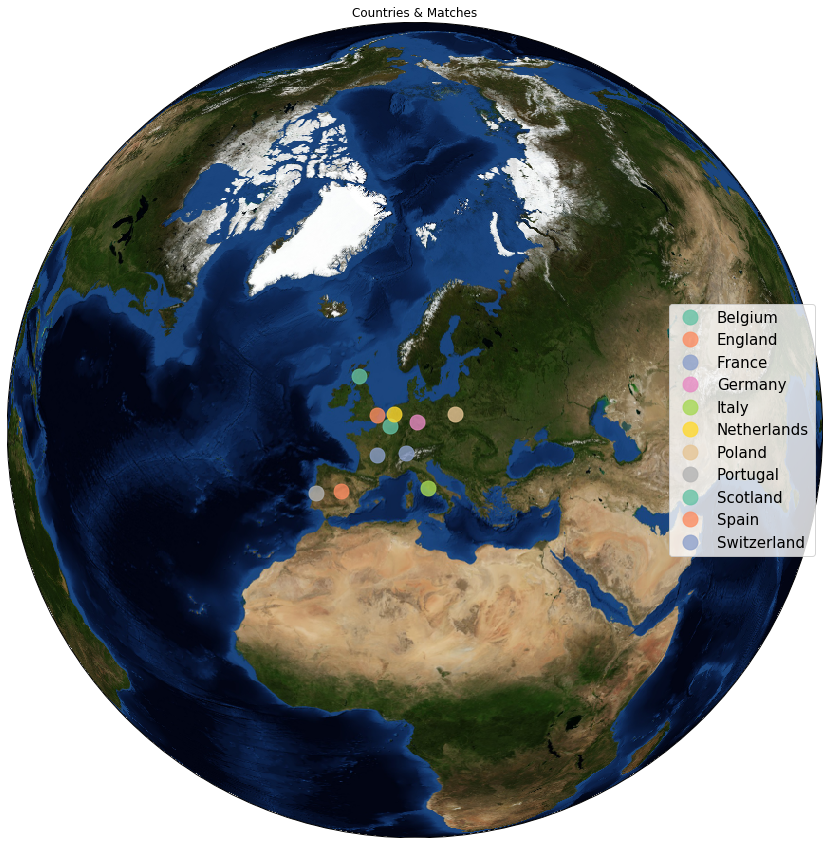

In [65]:
#getting lat lon info
leagues_by_countries = db.dfs['leagues_by_countries']
lat_long = db.lat_long
country_info  = leagues_by_countries.merge(lat_long, left_on="country", right_on="name", how="left")
country_info  = country_info.drop(["country_id","country_y","name"],axis = 1)


m3 = Basemap(projection='ortho', resolution=None, lat_0=50, lon_0=10,urcrnrlat=80,llcrnrlat=-80)

plt.figure(figsize=(15, 15))

country = list(country_info["country_x"].unique())
c       = sns.color_palette("Set2",len(country))
label   = country

def function(country,c,label):
    lat = list(country_info[country_info["country_x"] == country].latitude)
    lon = list(country_info[country_info["country_x"] == country].longitude)
    x,y = m3(lon,lat)
    m3.plot(x,y,"go",markersize=15,color=j,alpha=.8,label=i)

for i,j in zip(country,c):
    function(i,j,i)

m3.bluemarble(scale=0.5)
plt.legend(loc="center right",frameon=True,prop={"size":15}).get_frame().set_facecolor("white")
plt.title("Countries & Matches")
plt.show()


In [66]:
db.dfs.keys()

dict_keys(['countries', 'leagues', 'matches', 'players', 'player_attributes', 'teams', 'team_attributes', 'sqlite_sequences', 'players_and_attr', 'players_in_2016', 'leagues_by_countries', 'matches_with_less_attr', 'leagues_and_matches'])

In [67]:
df = db.dfs['leagues_and_matches']

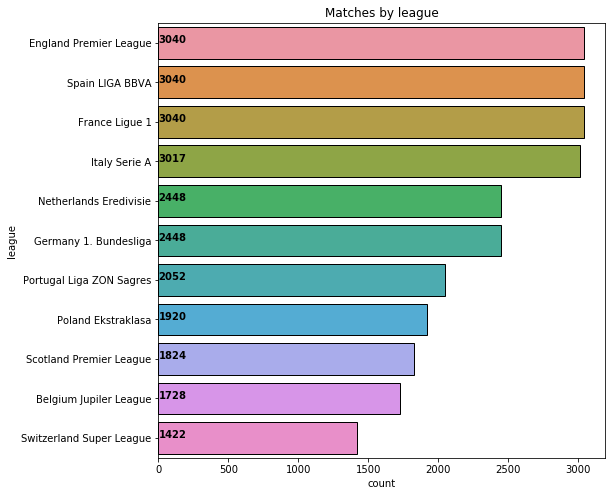

In [68]:
plt.figure(figsize=(8,8))
ax = sns.countplot(y = df["league"],
                   order=df["league"].value_counts().index,
                   linewidth = 1,
                   edgecolor = "k"*df["league"].nunique()
                 )
for i,j in enumerate(df["league"].value_counts().values):
    ax.text(.7,i,j,weight = "bold")
plt.title("Matches by league")
plt.show()

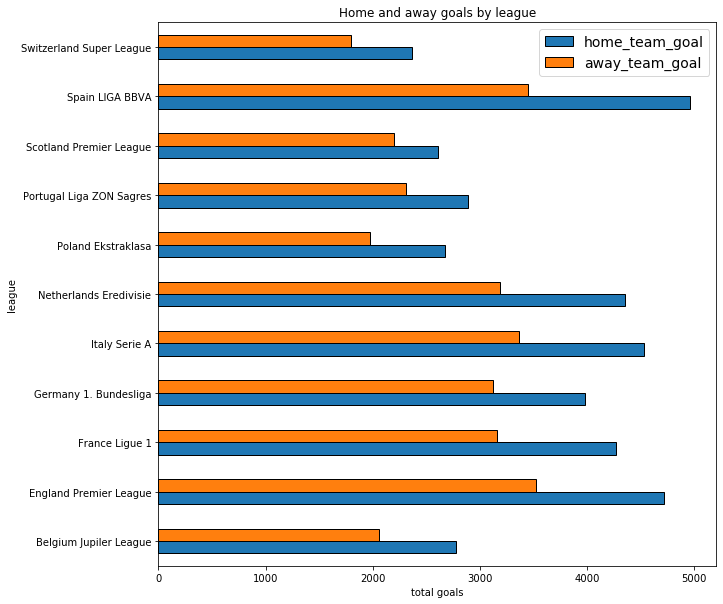

In [69]:
df.groupby("league").agg({"home_team_goal":"sum","away_team_goal":"sum"}).plot(kind="barh",
                                                                                 figsize = (10,10),
                                                                                 edgecolor = "k",
                                                                                 linewidth =1
                                                                                )
plt.title("Home and away goals by league")
plt.legend(loc = "best" , prop = {"size" : 14})
plt.xlabel("total goals")
plt.show()